## Подготовка данных

### Подключение библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score, auc, classification_report
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

### Откроем и изучим файл


In [ ]:
data = pd.read_csv('data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В столбце "Tenure" есть пропуски

In [ ]:
display(data.describe())

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Кажется со статистикой всё в порядке, идём дальше


### Проверим на дубликаты и пропущенные значения


In [ ]:
print("Дубликаты:",data.duplicated().sum())

Дубликаты: 0


In [ ]:
print("Пропуски по столбцам:",data.isnull().sum())

Пропуски по столбцам: RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64


### Посмотрим на текущий коэффициент корреляции

Text(0.5, 1.0, 'Матрица корреляции')

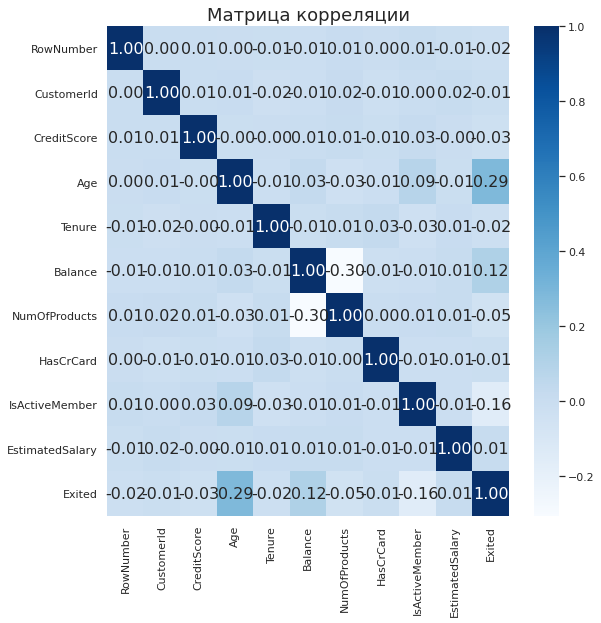

In [ ]:
plt.figure(figsize=(9,9))
sns.heatmap(data.corr(), annot=True, cmap="Blues", fmt='.2f', annot_kws={'size':16})
plt.title("Матрица корреляции", fontsize = 18)

Никакой корреляции нет, значит мы можем заполнить столбец нулевыми значениями

In [ ]:
data_clean = data.copy()
data_clean.dropna()
data['Tenure'] = data["Tenure"].fillna(0)
print("Пропуски по столбцам:",data.isnull().sum())

Пропуски по столбцам: RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


### Удалим столбцы, которые нам не пригодятся

In [ ]:
data = data.drop(['RowNumber','CustomerId','Surname'], axis=1)

### Избежим дамми-ловушек

In [ ]:

data = pd.get_dummies(data, drop_first=True)


### Применим стандартизацию

In [ ]:
scaler = StandardScaler()
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
8998,0.228325,-0.087870,10.0,0.114666,1,1,0,-0.937639,1,0,0
1239,-0.857253,-1.031487,7.0,-1.234387,2,1,0,-0.443975,0,0,1
9247,1.386275,-0.937126,7.0,0.069032,2,1,0,-0.600094,0,1,1
6514,-0.919286,-1.220211,7.0,-1.234387,2,0,0,-1.616593,0,1,1
8312,-0.671154,0.761386,6.0,-0.089976,1,1,0,-0.720802,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1727,0.249003,-0.276593,4.0,-1.234387,2,1,1,-1.667870,0,1,0
8980,-0.019807,-0.370955,3.0,1.439986,2,1,1,-1.299532,1,0,0
5566,-0.195567,0.289577,3.0,0.796435,1,0,1,-1.518806,1,0,1
2414,-0.991658,1.233195,9.0,-1.234387,1,1,0,1.304853,0,0,0


### Создадим тренировочную, тестовую и валидационную выборки:

Сначала мы перетасуем весь набор данных (df.sample (frac = 1)), а затем разделим наш набор данных на следующие части:

- 50% - обучающий набор;
- 25% - валидационный набор;
- 25% - тестовый.

In [ ]:
train, validate, test = np.split(data.sample(frac=1), [int(.5*len(data)), int(.75*len(data))])

In [ ]:
features_valid = validate.drop(['Exited'], axis=1)
target_valid = validate['Exited']

features_train = train.drop(['Exited'], axis=1)
target_train = train['Exited']

features_test = test.drop(['Exited'], axis=1)
target_test = test['Exited']

print('Размер валидационной выборки:', target_valid.shape[0])
print('Размер обучающей выборки:', target_train.shape[0])
print('Размер тестовой выборки:',target_test.shape[0])

Размер валидационной выборки: 2500
Размер обучающей выборки: 5000
Размер тестовой выборки: 2500



### Вывод:
- Изучили датасет
- Нашли и заполнили медианой пустые значения в столбце Tenure
- Других отклонений по статистике и дубликатов не обнаружили, так же нет взаимосвязей между параметрами
- Избавились от ловушек и стандартизировали признаки
- Разделили датасет на обучающую, валидационную и тестовую выборки

## Исследование задачи

### Посмотрим как работает модель решающего дерева без вмешательств. Посчитаем нужные метрики для модели(F-меру и Roc-Auc)

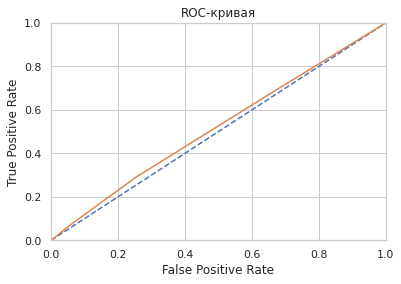

Auc-rocs is: 0.519995797337838
F1 is: 0.109375
Accuracy: 0.772


In [ ]:
model = KNeighborsClassifier(n_neighbors = 5)
model.fit(features_train,target_train)
predictions = model.predict(features_valid)
score = accuracy_score(target_valid, predictions)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(target_valid, probabilities_one_valid) 

plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
fscore = f1_score(target_valid, predictions)
print('Auc-rocs is:',auc_roc)
print('F1 is:',fscore)
print("Accuracy:", score)

### Посмотрим как работает модель случайного леса без вмешательств. Посчитаем нужные метрики для модели (F-меру и Roc-Auc)

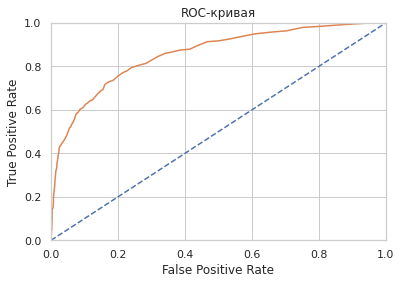

Auc-rocs is: 0.8559702797202797
F1 is: 0.12113720642768849
Accuracy: 0.7628


In [ ]:
model1 = RandomForestClassifier(random_state=12345)
model1.fit(features_train, target_train)
predictions1 = model1.predict(features_test)
score1 = accuracy_score(target_test, predictions1)
probabilities_valid1 = model1.predict_proba(features_valid)
probabilities_one_valid1 = probabilities_valid1[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(target_valid, probabilities_one_valid1) 
auc_roc = roc_auc_score(target_valid, probabilities_one_valid1)
fscore = f1_score(target_valid, predictions1)
plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()


print('Auc-rocs is:',auc_roc)
print('F1 is:',fscore)
print("Accuracy:", best_score_f)

Оставляем модель случайного леса. Результаты по F-мере и Auc-rocs немного выше. Попробуем улучшить ситуацию, вдруг получится.

Посмотрим на баланс через случайный лес

0    0.8904
1    0.1096
dtype: float64


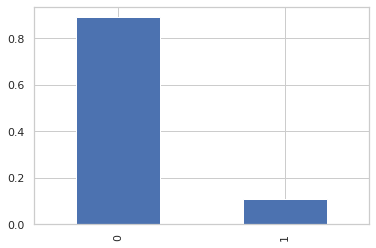

In [ ]:
model2 = RandomForestClassifier(random_state=12345, n_estimators=10, max_depth=None)
model2.fit(features_train, target_train)
predictions2 = pd.Series(model2.predict(features_valid))
class_frequency = predictions2.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')


## Борьба с дисбалансом

Перебор цикла с class_weight='balanced'

In [ ]:
for depth,estimator in itertools.product(range(1,30,5), range(1,101,50)):
    model3 = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=estimator, class_weight='balanced')
    model3.fit(features_train, target_train)
    predictions3 = model3.predict(features_valid)
    score = accuracy_score(predictions3, target_valid)
    fscore = f1_score(target_valid, predictions3)
    probabilities_valid3 = model3.predict_proba(features_valid)
    probabilities_one_valid3 = probabilities_valid3[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(target_valid, probabilities_one_valid3)
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid3)
    print('Depth: {: >5.0f}       |   Estimators: {:>5.0f}       |   Auc-rocs: {:>5.4f}'.format(depth, estimator,auc_roc))
    print('Accuracy: {: >5.4f}   |   F1_Score: {: >5.4f}'.format(score,fscore))
    print('------------------------------------------------------')

Depth:     1       |   Estimators:     1       |   Auc-rocs: 0.5657
Accuracy: 0.8164   |   F1_Score: 0.2363
------------------------------------------------------
Depth:     1       |   Estimators:    51       |   Auc-rocs: 0.7995
Accuracy: 0.7296   |   F1_Score: 0.5192
------------------------------------------------------
Depth:     6       |   Estimators:     1       |   Auc-rocs: 0.7765
Accuracy: 0.7648   |   F1_Score: 0.5377
------------------------------------------------------
Depth:     6       |   Estimators:    51       |   Auc-rocs: 0.8538
Accuracy: 0.7956   |   F1_Score: 0.5998
------------------------------------------------------
Depth:    11       |   Estimators:     1       |   Auc-rocs: 0.7013
Accuracy: 0.7632   |   F1_Score: 0.5067
------------------------------------------------------
Depth:    11       |   Estimators:    51       |   Auc-rocs: 0.8583
Accuracy: 0.8524   |   F1_Score: 0.6269
------------------------------------------------------
Depth:    16       |  

F1_score показал результат: 0.6269 и accuracy_score: 0.8524 при глубине 11, Auc-rocs 0.8583 и числе деревьев 51. Попробуем улучшить этот показатель.

### Увеличение выборки

In [ ]:
def upsampling(features, target, repeat):
    features_zeros = features_train[target_train == 0]
    features_ones = features_train[target_train == 1]
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled


for repeat in range(1,10,1):
    features_upsampled, target_upsampled = upsampling(features_train, target_train, repeat)

    model4 = RandomForestClassifier(random_state=12345)
    model4.fit(features_upsampled, target_upsampled)
    predictions4 = model4.predict(features_valid)
    probabilities_valid4 = model4.predict_proba(features_valid)
    probabilities_one_valid4 = probabilities_valid4[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(target_valid, probabilities_one_valid4)
    print("F1_Score: {: >5.3f}  |   Repeats : {: >5.0f}   |   Auc-rocs: {:>5.4f}".format(f1_score(target_valid, predictions4),repeat,roc_auc_score(target_valid, probabilities_one_valid4)))

F1_Score: 0.561  |   Repeats :     1   |   Auc-rocs: 0.8571
F1_Score: 0.597  |   Repeats :     2   |   Auc-rocs: 0.8551
F1_Score: 0.606  |   Repeats :     3   |   Auc-rocs: 0.8540
F1_Score: 0.611  |   Repeats :     4   |   Auc-rocs: 0.8528
F1_Score: 0.602  |   Repeats :     5   |   Auc-rocs: 0.8561
F1_Score: 0.624  |   Repeats :     6   |   Auc-rocs: 0.8523
F1_Score: 0.608  |   Repeats :     7   |   Auc-rocs: 0.8503
F1_Score: 0.611  |   Repeats :     8   |   Auc-rocs: 0.8519
F1_Score: 0.607  |   Repeats :     9   |   Auc-rocs: 0.8514


Уменьшение выборки

In [ ]:
def downsampling(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

for i in np.arange(0.03, 0.31, 0.03):
    features_downsampled, target_downsampled = downsampling(features_train, target_train, i)
    model5 = RandomForestClassifier(random_state=12345)
    model5.fit(features_downsampled, target_downsampled)
    predictions5 = model5.predict(features_valid)
    probabilities_valid5 = model5.predict_proba(features_valid)
    probabilities_one_valid5 = probabilities_valid5[:, 1]

    print("F1_Score: {: >5.3f}  |  Fractions : {: >5.3f}   |   Auc-rocs: {:>5.4f}".format(f1_score(target_valid, predictions5), i, roc_auc_score(target_valid, probabilities_one_valid5)))

F1_Score: 0.366  |  Fractions : 0.030   |   Auc-rocs: 0.7989
F1_Score: 0.414  |  Fractions : 0.060   |   Auc-rocs: 0.8281
F1_Score: 0.472  |  Fractions : 0.090   |   Auc-rocs: 0.8427
F1_Score: 0.501  |  Fractions : 0.120   |   Auc-rocs: 0.8454
F1_Score: 0.531  |  Fractions : 0.150   |   Auc-rocs: 0.8464
F1_Score: 0.554  |  Fractions : 0.180   |   Auc-rocs: 0.8538
F1_Score: 0.555  |  Fractions : 0.210   |   Auc-rocs: 0.8504
F1_Score: 0.570  |  Fractions : 0.240   |   Auc-rocs: 0.8501
F1_Score: 0.579  |  Fractions : 0.270   |   Auc-rocs: 0.8491
F1_Score: 0.585  |  Fractions : 0.300   |   Auc-rocs: 0.8532


Вывод:

Нашли в цикле лучшие параметры: глубина - 6, количество деревьев - 51. F1 score - 0.6002
Улучшение модели не привело к увеличению f1_score :(

## Тестирование модели

Проверим модель на тестовой выборке

In [ ]:
model6 = RandomForestClassifier(n_estimators = 51, max_depth=6, class_weight='balanced', random_state=12345)
model6.fit(features_train, target_train)
predicted_valid6 = model6.predict(features_test)
accuracy_valid = accuracy_score(predicted_valid6, target_test)
print('Accuracy is:', accuracy_valid)
print('F1_Score is:', f1_score(target_test, predicted_valid6))

Accuracy is: 0.8172
F1_Score is: 0.609735269000854


ROC-кривая

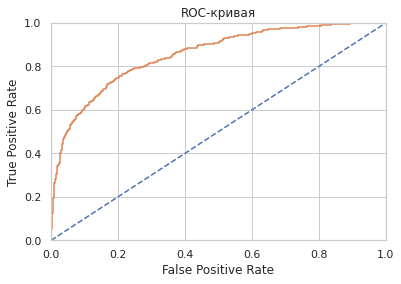

Auc-rocs is: 0.8538442113442114


In [ ]:
model7 = RandomForestClassifier(n_estimators = 51, max_depth=6, class_weight='balanced', random_state=12345)
model7.fit(features_train, target_train)

probabilities_valid7 = model7.predict_proba(features_valid)
probabilities_one_valid7 = probabilities_valid7[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(target_valid, probabilities_one_valid7) 

plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(target_valid, probabilities_one_valid7)

print('Auc-rocs is:',auc_roc)

Посмотрим ещё раз на сводную по статистике класса

In [ ]:
print(classification_report(target_test, predicted_valid6))

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      1993
           1       0.49      0.74      0.59       507

    accuracy                           0.79      2500
   macro avg       0.71      0.77      0.73      2500
weighted avg       0.84      0.79      0.81      2500




### Вывод:
- Подготовили датасет для прогнозирования оттока клиентов
- Использовали модель RandomForestClassifier.
- Методами Upsampling и Downsampling пытались улучшить f1_score, но это не принесло результата. 
- Лучший показатель f1_score - 0.609.
- Отрисовали ROC-кривую  и получили roc auc score : 0.853.
- Из результата следует, что модель предсказывает достаточно хорошо, так как показатель больше 0.5.